## Vistion Transformer Training

In [1]:
!pip install -q git+https://github.com/huggingface/transformers

In [13]:
import torchvision
from torchvision.transforms import ToTensor

path = '../model_dev/Data_CMC_COADEL_224_1/'

train_ds = torchvision.datasets.ImageFolder(path + 'train/', transform=ToTensor())
val_ds = torchvision.datasets.ImageFolder(path + 'val/', transform=ToTensor())

In [4]:
from datasets import load_metric

metric = load_metric("accuracy")

/tmp/ipykernel_697938/1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [6]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
            return logits, loss.item()
        else:
            return logits, None

In [7]:
EPOCHS = 3
BATCH_SIZE = 10
LEARNING_RATE = 2e-5

In [8]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [14]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(val_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

# Train the model
for epoch in range(EPOCHS):        
    for step, (x, y) in enumerate(train_loader):
        # Change input array into list with each batch being one element
        x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
        # Remove unecessary dimension
        for index, array in enumerate(x):
            x[index] = np.squeeze(array)
        # Apply feature extractor, stack back into 1 tensor and then convert to tensor
        x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
        # Send to GPU if available
        x, y  = x.to(device), y.to(device)
        b_x = Variable(x)   # batch x (image)
        b_y = Variable(y)   # batch y (target)
        # Feed through model
        output, loss = model(b_x, None)
        # Calculate loss
        if loss is None: 
            loss = loss_func(output, b_y)   
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step()

        if step % 50 == 0:
            # Get the next batch for testing purposes
            test = next(iter(test_loader))
            test_x = test[0]
            # Reshape and get feature matrices as needed
            test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
            for index, array in enumerate(test_x):
                test_x[index] = np.squeeze(array)
            test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
            # Send to appropirate computing device
            test_x = test_x.to(device)
            test_y = test[1].to(device)
            # Get output (+ respective class) and compare to target
            test_output, loss = model(test_x, test_y)
            test_output = test_output.argmax(1)
            # Calculate Accuracy
            accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
            print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

Number of train samples:  37950
Number of test samples:  12334
Detected Classes are:  {'Mitosis': 0, 'Nonmitosis': 1}
Epoch:  0 | train loss: 0.5903 | test accuracy: 0.80
Epoch:  0 | train loss: 0.5108 | test accuracy: 0.70
Epoch:  0 | train loss: 0.3850 | test accuracy: 0.90
Epoch:  0 | train loss: 0.5025 | test accuracy: 0.80
Epoch:  0 | train loss: 0.6116 | test accuracy: 0.70
Epoch:  0 | train loss: 0.5592 | test accuracy: 0.70
Epoch:  0 | train loss: 0.3728 | test accuracy: 0.80
Epoch:  0 | train loss: 0.4772 | test accuracy: 0.80
Epoch:  0 | train loss: 0.6497 | test accuracy: 0.70
Epoch:  0 | train loss: 0.6524 | test accuracy: 0.80
Epoch:  0 | train loss: 0.2058 | test accuracy: 1.00
Epoch:  0 | train loss: 0.3595 | test accuracy: 0.90
Epoch:  0 | train loss: 0.6156 | test accuracy: 0.60
Epoch:  0 | train loss: 0.2270 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2895 | test accuracy: 0.80
Epoch:  0 | train loss: 0.6421 | test accuracy: 0.80
Epoch:  0 | train loss: 0.6778 | t

torch.Size([1, 3, 224, 224])


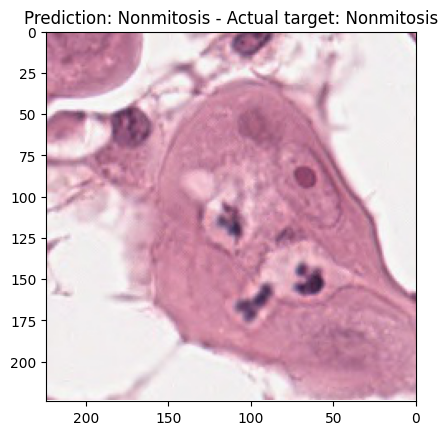

In [16]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(val_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
with torch.no_grad():
    
    inputs, target = next(iter(eval_loader))
    # Reshape and get feature matrices as needed
    print(inputs.shape)
    inputs = inputs[0].permute(1, 2, 0)
    # Save original Input
    originalInput = inputs
    for index, array in enumerate(inputs):
        inputs[index] = np.squeeze(array)
    inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

    # Send to appropriate computing device
    inputs = inputs.to(device)
    target = target.to(device)

    # Generate prediction
    prediction, loss = model(inputs, target)

    # Predicted class value using argmax
    predicted_class = np.argmax(prediction.cpu())
    value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
    value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]

    # Show result
    plt.imshow(originalInput)
    plt.xlim(224,0)
    plt.ylim(224,0)
    plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
    plt.show()

In [17]:
!pwd

/home/jmwolf/repos/XAI_Healthcare/model_dev


In [19]:
torch.save(model, 'trns_model.pt')

In [20]:
MODEL_PATH = 'trns_model.pt'
model = torch.load(MODEL_PATH)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_